In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Load data
india = pd.read_csv('india_clean.csv')
jordan = pd.read_csv('jordan_clean.csv')
florida = pd.read_csv('florida_clean.csv')
california = pd.read_csv('california_clean.csv')

# Ensure LOS >= 1
for df in [india, jordan, florida, california]:
    if "los" in df.columns:
        df["los"] = df["los"].clip(lower=1)

# Registry
dataset_registry = {
    "India": india,
    "Jordan": jordan,
    "Florida": florida,
    "California": california
}

numerical_features = ['age', 'gcs']
categorical_features = ['sex', 'hr_cat', 'rr_cat', 'sbp_cat', 'MOI']

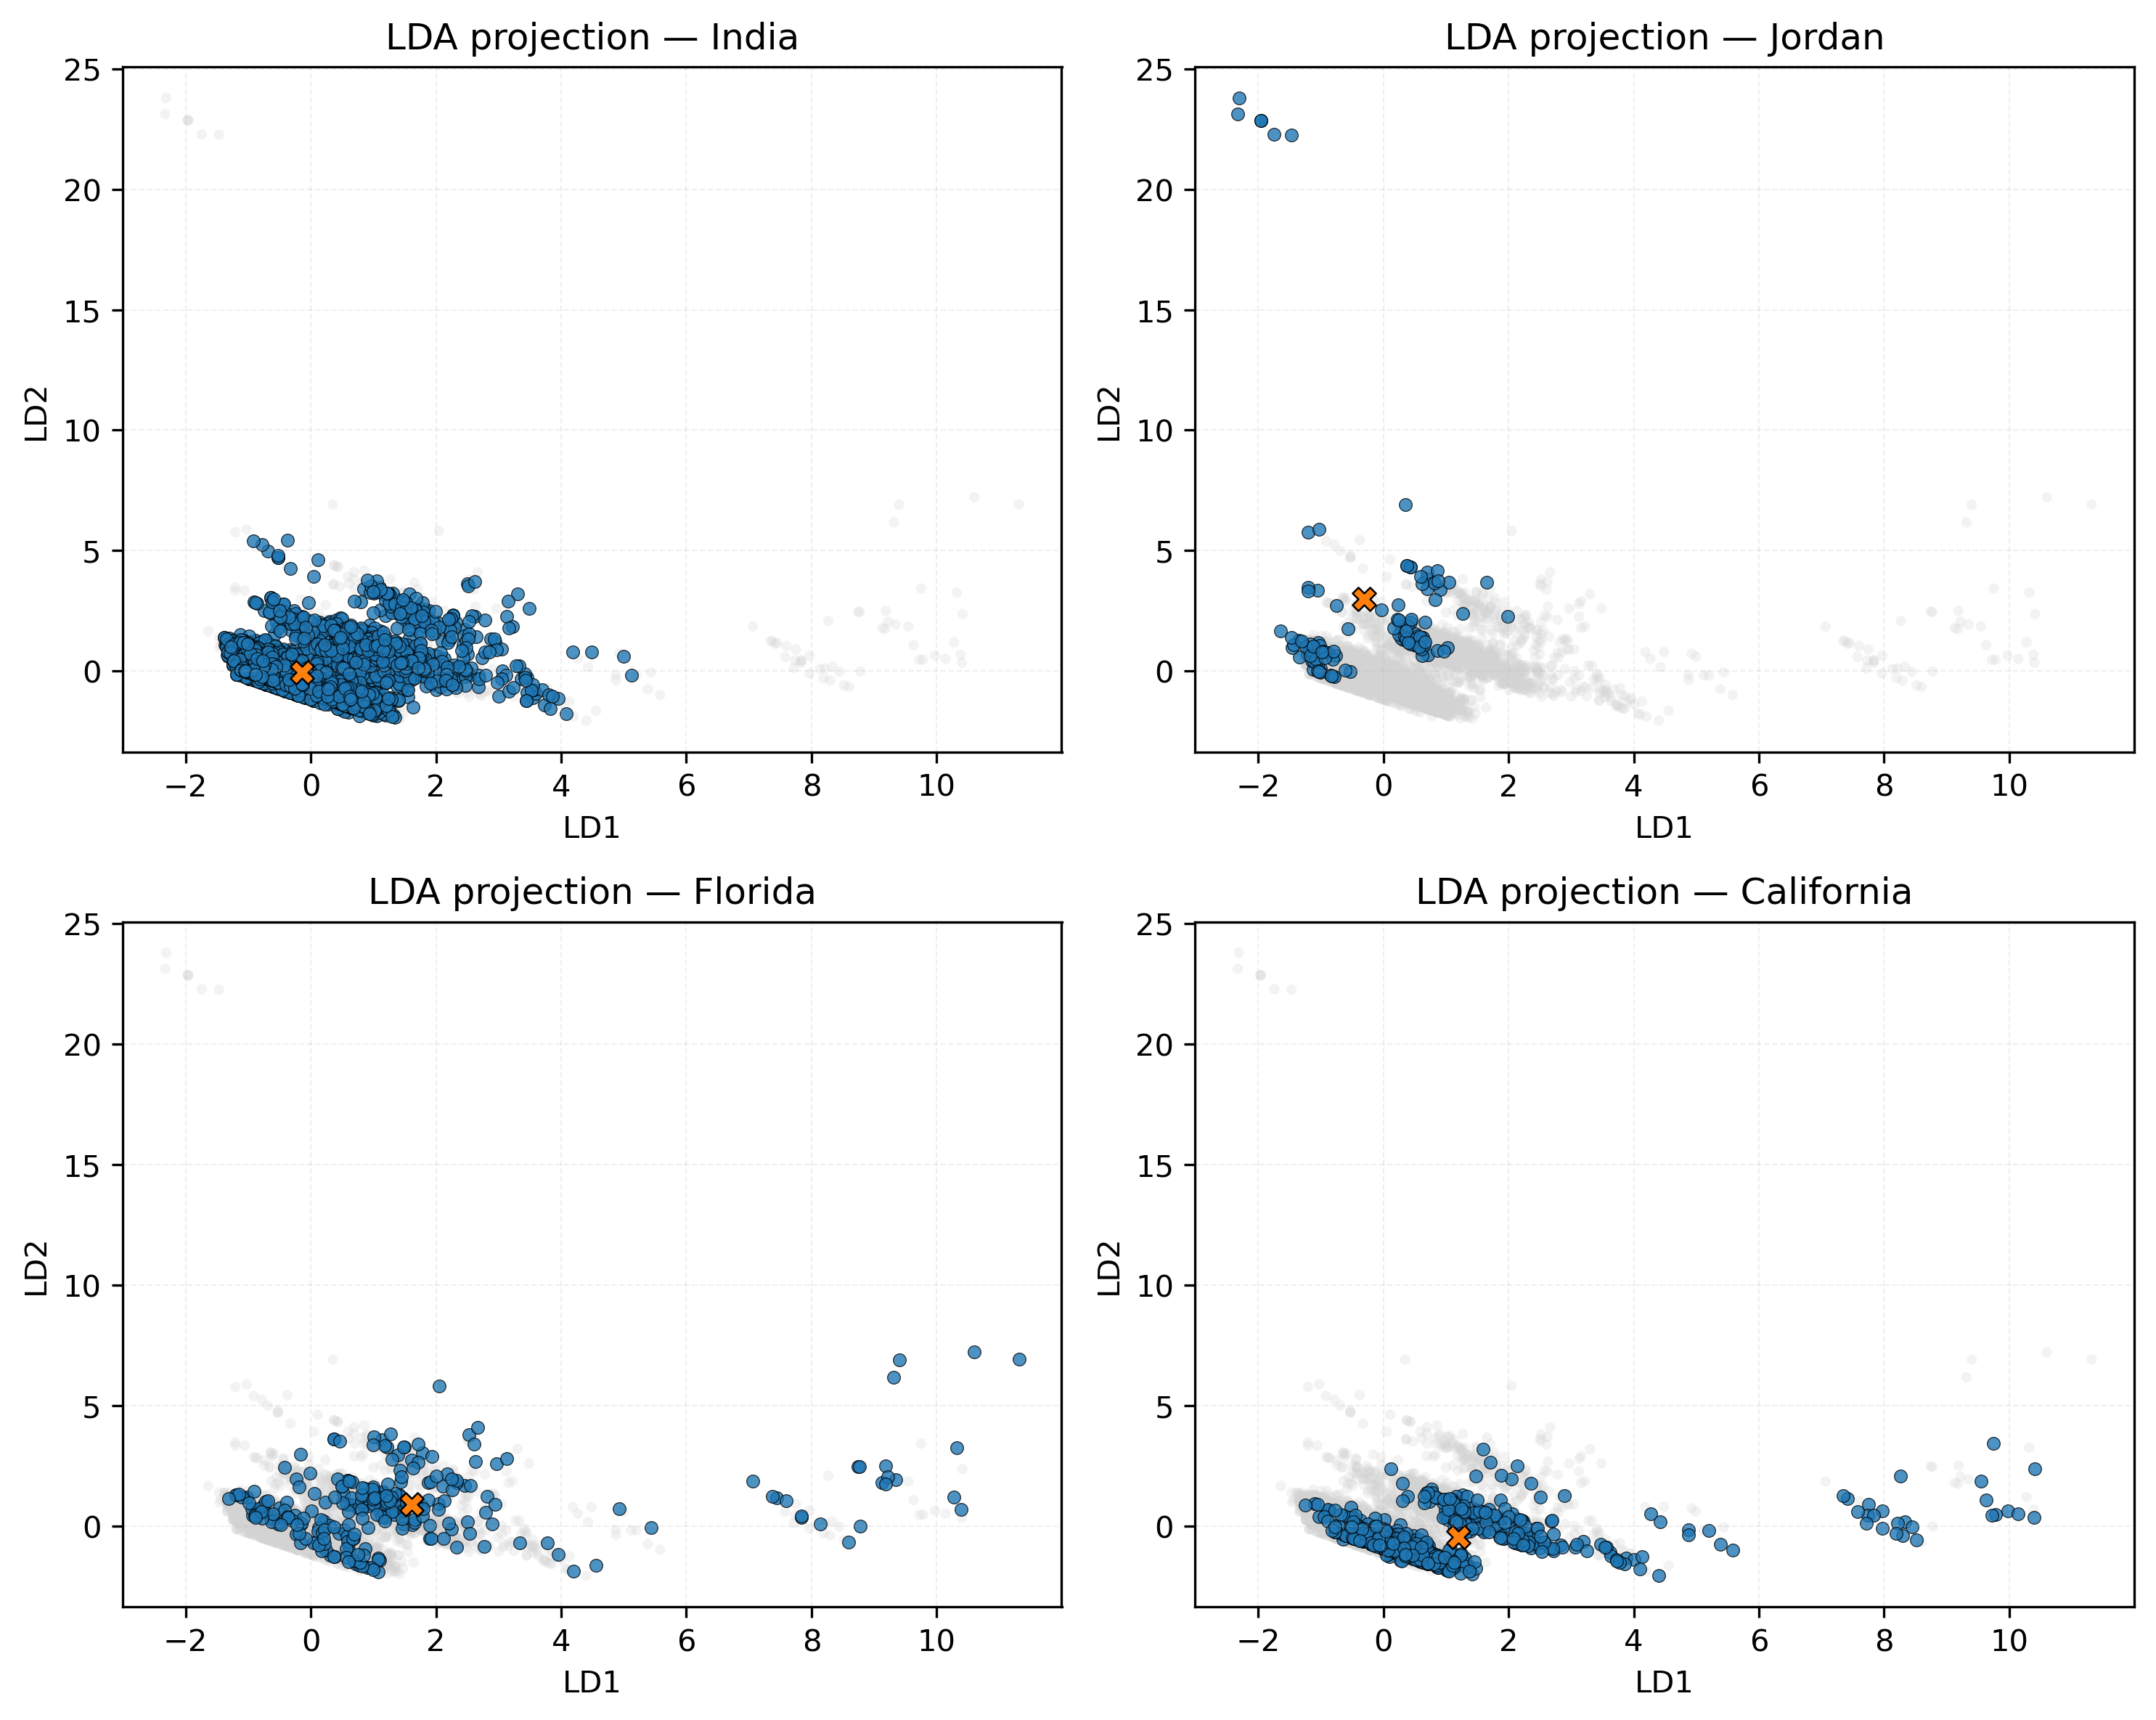

In [27]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# -----------------------------
# Combine datasets with cohort labels
# -----------------------------
dfs = []
for name, df in dataset_registry.items():
    temp = df.copy()
    temp["cohort"] = name
    dfs.append(temp)
data_all = pd.concat(dfs, ignore_index=True)

# Features/labels
X = data_all[numerical_features + categorical_features]
y = data_all["cohort"].astype(str)  # ensure string labels
cohorts = y.unique().tolist()

# -----------------------------
# Preprocessing (dense OHE) + LDA
# -----------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(drop="first", sparse_output=False), categorical_features)
    ]
)

lda = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("reduce", LinearDiscriminantAnalysis(n_components=2))
])

X_lda = lda.fit_transform(X, y)

# Pack into a DataFrame for convenience
plot_df = pd.DataFrame({
    "LD1": X_lda[:, 0],
    "LD2": X_lda[:, 1],
    "cohort": y.values
})

# -----------------------------
# Figure: 4 subplots, one per cohort, 300 dpi
# -----------------------------
fig, axes = plt.subplots(2, 2, figsize=(10, 8), dpi=300)
axes = axes.ravel()

# Fix axes limits across all panels for fair visual comparison
x_pad = 0.05 * (plot_df["LD1"].max() - plot_df["LD1"].min() + 1e-9)
y_pad = 0.05 * (plot_df["LD2"].max() - plot_df["LD2"].min() + 1e-9)
xlim = (plot_df["LD1"].min() - x_pad, plot_df["LD1"].max() + x_pad)
ylim = (plot_df["LD2"].min() - y_pad, plot_df["LD2"].max() + y_pad)

for ax, cohort in zip(axes, cohorts):
    mask = plot_df["cohort"] == cohort

    # Others (light gray)
    ax.scatter(
        plot_df.loc[~mask, "LD1"], plot_df.loc[~mask, "LD2"],
        s=12, alpha=0.25, c="lightgray", edgecolors="none"
    )

    # Highlight this cohort
    ax.scatter(
        plot_df.loc[mask, "LD1"], plot_df.loc[mask, "LD2"],
        s=18, alpha=0.8, edgecolors="black", linewidths=0.3
    )

    # Optional: mark cohort centroid
    cx, cy = plot_df.loc[mask, ["LD1", "LD2"]].mean()
    ax.scatter(cx, cy, s=60, marker="X", edgecolors="black", linewidths=0.6)
    ax.set_title(f"LDA projection — {cohort}")

    ax.set_xlabel("LD1")
    ax.set_ylabel("LD2")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.grid(alpha=0.2, linestyle="--", linewidth=0.5)

# If there are fewer than 4 cohorts, hide extra axes; if more, adjust layout logic
for j in range(len(cohorts), 4):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


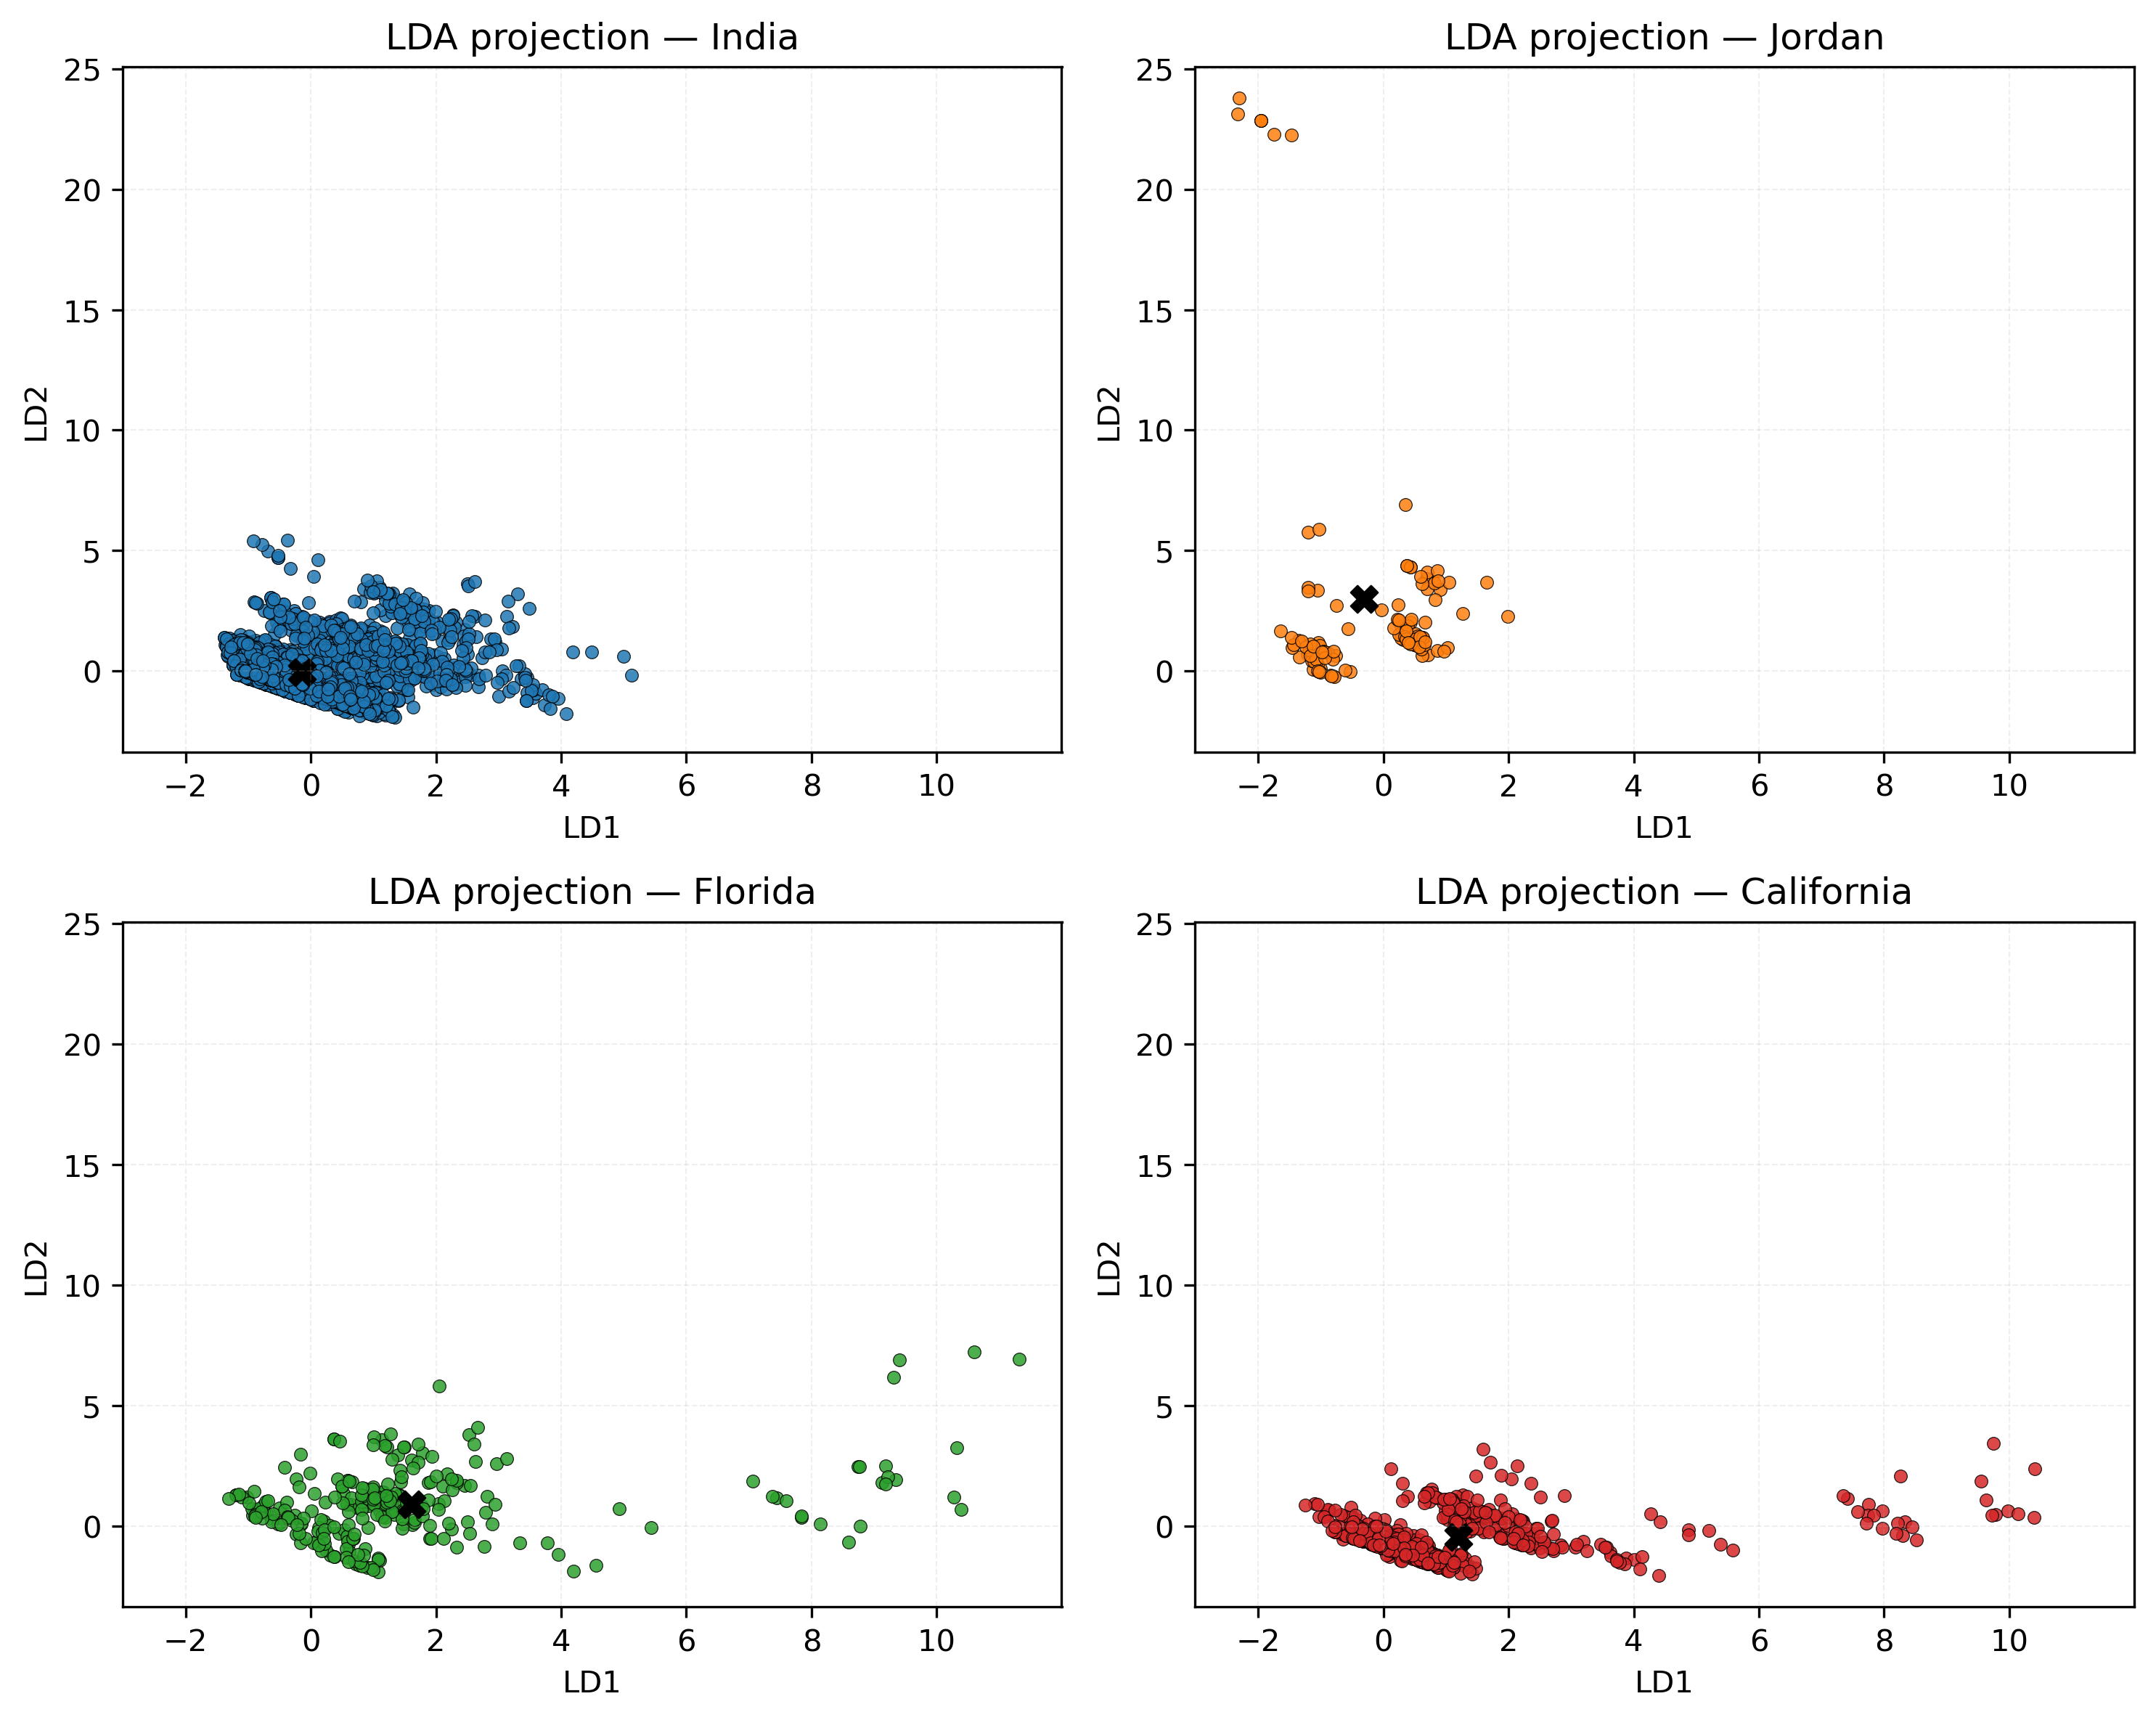

In [40]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# -----------------------------
# Combine datasets with cohort labels
# -----------------------------
dfs = []
for name, df in dataset_registry.items():
    temp = df.copy()
    temp["cohort"] = name
    dfs.append(temp)
data_all = pd.concat(dfs, ignore_index=True)

# Features/labels
X = data_all[numerical_features + categorical_features]
y = data_all["cohort"].astype(str)
cohorts = y.unique().tolist()

# Choose distinct colors per cohort
color_map = {
    "India":       "tab:blue",
    "Jordan":      "tab:orange",
    "Florida":     "tab:green",
    "California":  "tab:red",
}
# fallback if names differ
for c in cohorts:
    color_map.setdefault(c, None)  # matplotlib will auto-assign if missing

# -----------------------------
# Preprocessing (dense OHE) + LDA
# -----------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(drop="first", sparse_output=False), categorical_features)
    ]
)

lda = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("reduce", LinearDiscriminantAnalysis(n_components=2))
])

X_lda = lda.fit_transform(X, y)

plot_df = pd.DataFrame({"LD1": X_lda[:, 0], "LD2": X_lda[:, 1], "cohort": y.values})

# -----------------------------
# Figure: 4 subplots (2x2), 300 dpi, one cohort per panel
# -----------------------------
fig, axes = plt.subplots(2, 2, figsize=(10, 8), dpi=300)
axes = axes.ravel()

# Set shared axis limits for comparability
x_pad = 0.05 * (plot_df["LD1"].max() - plot_df["LD1"].min() + 1e-9)
y_pad = 0.05 * (plot_df["LD2"].max() - plot_df["LD2"].min() + 1e-9)
xlim = (plot_df["LD1"].min() - x_pad, plot_df["LD1"].max() + x_pad)
ylim = (plot_df["LD2"].min() - y_pad, plot_df["LD2"].max() + y_pad)

for ax, cohort in zip(axes, cohorts):
    mask = plot_df["cohort"] == cohort

    # Plot ONLY this cohort in its color (no overlay of others)
    ax.scatter(
        plot_df.loc[mask, "LD1"],
        plot_df.loc[mask, "LD2"],
        s=18, alpha=0.85,
        c=color_map.get(cohort),
        edgecolors="black", linewidths=0.3
    )

    # Mark centroid
    cx, cy = plot_df.loc[mask, ["LD1", "LD2"]].mean()
    ax.scatter(cx, cy, s=80, marker="X", edgecolors="black", linewidths=0.6, c="black")

    ax.set_title(f"LDA projection — {cohort}")
    ax.set_xlabel("LD1"); ax.set_ylabel("LD2")
    ax.set_xlim(xlim); ax.set_ylim(ylim)
    ax.grid(alpha=0.2, linestyle="--", linewidth=0.5)

# Hide unused axes if fewer than 4 cohorts
for j in range(len(cohorts), 4):
    axes[j].axis("off")

plt.tight_layout()
plt.show()
